# Course:  Convolutional Neural Networks for Image Classification

## Section-8
### Augment and equalize images in dataset

**Description:**  
*Add transformed images into dataset  
Make number of images equal for all classes  
Plot equalized histogram*  

**File:** *augment_and_equalize.ipynb*

### Algorithm:

**--> Step 1:** Open Traffic Signs dataset  
**--> Step 2:** Concatenate arrays  
**--> Step 3:** Define functions for augmentation  
**--> Step 4:** Implement augmentation and equalization  
**--> Step 5:** Concatenating temporary arrays to main arrays  
**--> Step 6:** Plot histogram to show distribution  
**--> Step 7:** Shuffle data along the first axis  
**--> Step 8:** Split arrays into train, validation and test  
**--> Step 9:** Save final Numpy arrays into one HDF5 binary file  
**--> Step 10:** Visualize 100 examples  


**Result:**  
- HDF5 binary file with augmented Traffic Signs dataset

## Importing libraries

In [1]:
# Importing needed libraries
import matplotlib.pyplot as plt
import numpy as np
import h5py
import cv2

from sklearn.utils import shuffle


# Importing library to see calculation progress inside loops in Real Time
# To install, use following command: pip install tqdm
# Don't forget to activate environment in which you're working
from tqdm import tqdm


## Setting up full path

In [2]:
# Full or absolute path to 'Section3' with Traffic Signs dataset
# (!) On Windows, the path should look like following:
# r'C:\Users\your_name\PycharmProjects\CNNCourse\Section3'
# or:
# 'C:\\Users\\your_name\\PycharmProjects\\CNNCourse\\Section3'
full_path_to_Section3 = \
    'C:\\Users\\anaso\\OneDrive - Instituto Superior de Engenharia de Lisboa\\CNNCourse\\Section3'


## Step 1: Opening Traffic Signs dataset

In [3]:
# Opening saved Traffic Signs dataset from HDF5 binary file
# Initiating File object
# Opening file in reading mode by 'r'
# (!) On Windows, it might need to change
# this: + '/' +
# to this: + '\' +
# or to this: + '\\' +
with h5py.File(full_path_to_Section3 + '/' + 'dataset_ts.hdf5', 'r') as f:
    # Extracting saved arrays for training by appropriate keys
    # Saving them into new variables
    x_train = f['x_train']  # HDF5 dataset
    y_train = f['y_train']  # HDF5 dataset
    # Converting them into Numpy arrays
    x_train = np.array(x_train)  # Numpy arrays
    y_train = np.array(y_train)  # Numpy arrays

    # Extracting saved arrays for validation by appropriate keys
    # Saving them into new variables
    x_validation = f['x_validation']  # HDF5 dataset
    y_validation = f['y_validation']  # HDF5 dataset
    # Converting them into Numpy arrays
    x_validation = np.array(x_validation)  # Numpy arrays
    y_validation = np.array(y_validation)  # Numpy arrays

    # Extracting saved arrays for testing by appropriate keys
    # Saving them into new variables
    x_test = f['x_test']  # HDF5 dataset
    y_test = f['y_test']  # HDF5 dataset
    # Converting them into Numpy arrays
    x_test = np.array(x_test)  # Numpy arrays
    y_test = np.array(y_test)  # Numpy arrays


# Check point
print('Traffic Signs dataset is successfully opened')


Traffic Signs dataset is successfully opened


In [4]:
# Check point
# Showing shapes of loaded arrays
print(x_train.shape)
print(y_train.shape)
print(x_validation.shape)
print(y_validation.shape)
print(x_test.shape)
print(y_test.shape)


(36288, 48, 48, 3)
(36288,)
(12440, 48, 48, 3)
(12440,)
(3111, 48, 48, 3)
(3111,)


## Step 2: Concatenating arrays

In [5]:
# Concatenating arrays vertically
x_train = np.concatenate((x_train, x_validation, x_test), axis=0)
y_train = np.concatenate((y_train, y_validation, y_test), axis=0)


# Check point
# Showing shapes of concatenated arrays
print(x_train.shape)
print(y_train.shape)


(51839, 48, 48, 3)
(51839,)


## Step 3: Defining functions for augmentation

In [6]:
# Defining function for changing brightness
def brightness_changing(input_image):
    # Converting input image from RGB to HSV colour space
    image_hsv = cv2.cvtColor(input_image, cv2.COLOR_RGB2HSV)
    
    # Defining random value (positive or negative) for changing brightness
    # To make image darker or brighter
    n = np.random.choice([-1, 1])
    
    # Checking if n is negative
    if n == -1:
        # Preparing value to darken image with
        random_brightness = n * np.random.randint(low=5, high=10)
        
    # Otherwise, if n is positive
    elif n == 1:
        # Preparing value to brighten image with
        random_brightness = np.random.randint(low=50, high=75)
    
    # Changing Value channel for HSV image
    image_hsv[:, :, 2] += random_brightness
    
    # To exclude pixels' values that are less than 0 and more than 255,
    # Numpy function 'clip' is applied
    # It keeps values of array in the given range
    # And it replaces non-needed values with boundary numbers
    image_hsv[:, :, 2] = np.clip(image_hsv[:, :, 2], 0, 255)
    
    # Converting resulted HSV image back to RGB colour space
    image_rgb = cv2.cvtColor(image_hsv, cv2.COLOR_HSV2RGB)
    
    # Returning resulted image with changed brightness
    return image_rgb


# Check point
print('Function to randomly change brightness is successfully defined')


Function to randomly change brightness is successfully defined


In [7]:
# Defining function to rotate image around centre point
def rotation_changing(input_image):
    # Defining random angle for rotation (positive or negative)
    angle = np.random.randint(low=5, high=15) * np.random.choice([-1, 1])
    
    # Getting shape of input image
    height, width, channels = input_image.shape
    
    # Calculating coordinates (x, y) for centre point of input image
    centre_point = (int(width / 2), int(height / 2))
    
    # Calculating Affine Matrix
    affine_matrix = cv2.getRotationMatrix2D(centre_point, angle, scale=1)
    
    # Warping original image with Affine Matrix
    rotated_image = cv2.warpAffine(input_image, affine_matrix, (height, width))
    
    # Returning rotated image
    return rotated_image


# Check point
print('Function to randomly rotate image is successfully defined')


Function to randomly rotate image is successfully defined


In [8]:
# Defining function to project image
# by coordinates of quadrangle vertices
def perspective_changing_1(input_image):
    # Getting shape of input image
    height, width, channels = input_image.shape
    
    # Defining variables for vertices of input image
    x_min = 0
    y_min = 0
    x_max = width
    y_max = height
    
    # Prepering coordinates of quadrangle vertices
    # in the input image
    src = np.float32([[x_min, y_min],  # top-left
                      [x_max, y_min],  # top-right
                      [x_min, y_max],  # bottom-left
                      [x_max, y_max]]) # bottom-right
    
    # Preparing coordinates of corresponding quadrangle vertices
    # in the output image
    dst = np.float32([[x_min + 5, y_min + 5],  # top-left
                      [x_max - 5, y_min + 5],  # top-right
                      [x_min, y_max],          # bottom-left
                      [x_max, y_max]])         # bottom-right
    
    # Calculating perspective transformation matrix
    # from 4 pairs of the corresponding points
    matrix = cv2.getPerspectiveTransform(src, dst)
    
    # Applying perspective transformation
    # by found matrix to input image
    projected_image = cv2.warpPerspective(input_image, matrix, (height, width))
    
    # Returning projected image
    return projected_image


# Check point
print('First function to project image is successfully defined')


First function to project image is successfully defined


In [9]:
# Defining function to project image
# by coordinates of quadrangle vertices
def perspective_changing_2(input_image):
    # Getting shape of input image
    height, width, channels = input_image.shape
    
    # Defining variables for vertices of input image
    x_min = 0
    y_min = 0
    x_max = width
    y_max = height
    
    # Prepering coordinates of quadrangle vertices
    # in the input image
    src = np.float32([[x_min, y_min],  # top-left
                      [x_max, y_min],  # top-right
                      [x_min, y_max],  # bottom-left
                      [x_max, y_max]]) # bottom-right
    
    # Preparing coordinates of corresponding quadrangle vertices
    # in the output image
    dst = np.float32([[x_min, y_min],          # top-left
                      [x_max - 5, y_min + 5],  # top-right
                      [x_min, y_max],          # bottom-left
                      [x_max - 5, y_max - 5]]) # bottom-right
    
    # Calculating perspective transformation matrix
    # from 4 pairs of the corresponding points
    matrix = cv2.getPerspectiveTransform(src, dst)
    
    # Applying perspective transformation
    # by found matrix to input image
    projected_image = cv2.warpPerspective(input_image, matrix, (height, width))
    
    # Returning projected image
    return projected_image


# Check point
print('Second function to project image is successfully defined')


Second function to project image is successfully defined


## Step 4: Implementing augmentation and equalization

In [10]:
# Calculating number of images for every class
# Iterating all classes' indexes in 'y_train' array
# Using Numpy function 'unique'
# Returning sorted unique elements and their frequencies
classesIndexes, classesFrequency = np.unique(y_train, return_counts=True)


# Printing frequency (number of images) for every class
print('classes indexes:' , classesIndexes)
print()
print('classes frequency:', classesFrequency)


classes indexes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]

classes frequency: [ 270 2940 3000 1860 2640 2490  570 1890 1860 1950 2670 1740 2790 2880
 1050  840  570 1470 1590  270  450  420  510  660  360 1980  780  300
  690  360  600 1050  300  899  540 1590  510  270 2760  390  450  300
  330]


In [11]:
# Iterating all 43 classes
for i in range(len(classesIndexes)):
    # Option 1
    # Calculating how many examples is needed to add for current class
    # number_of_examples_to_add = int(1000000 / 43) - classesFrequency[i]
    # print('Class {0:02d} needs following number of images: {1}'.format(i, number_of_examples_to_add))
    
    # Option 2
    # Calculating how many examples is needed to add for current class
    number_of_examples_to_add = np.max(classesFrequency) + 10 - classesFrequency[i]
    # print('Class {0:02d} needs following number of images: {1}'.format(i, number_of_examples_to_add))
    
    # Preparing lists for collecting new images
    x_temp = []
    y_temp = []
    
    # Augmenting current class
    # Wrapping the loop with 'tqdm' in order to see the progress in Real Time
    for j in tqdm(range(number_of_examples_to_add)):
        # Getting indexes of images for current class in 'y_train' array
        image_indexes = np.where(y_train == i)  # tuple with array of needed indexes
        
        # Extracting only array itself
        image_indexes = image_indexes[0]  # Numpy array with needed indexes
        # print(image_indexes.shape)
        # print(image_indexes)
        
        # Defining random value to get random image
        n = np.random.randint(low=0, high=classesFrequency[i])
        
        # Getting random image from current class
        random_image = np.copy(x_train[image_indexes[n]])
        
        # Applying random brightness changing
        random_image = brightness_changing(random_image)
        
        # Choosing transformation technique
        m = np.random.choice([1, 2, 3])
        
        # Applying rotation around centre point
        if m == 1:
            random_image = rotation_changing(random_image)
        
        # Applying perspective transformation 1
        elif m == 2:
            random_image = perspective_changing_1(random_image)
        
        # Applying perspective transformation 2
        elif m == 3:
            random_image = perspective_changing_2(random_image)
        
        # Appending transformed image into the list
        x_temp.append(random_image)
        y_temp.append(i)
    
    # Converting lists into Numpy arrays
    x_temp = np.array(x_temp)  # Numpy arrays
    y_temp = np.array(y_temp)  # Numpy arrays
    
    # Saving prepared Numpy arrays into HDF5 binary file
    # for currently augmented class
    # Initiating File object
    # Creating files with names from '00.hdf5' to '42.hdf5'
    # Opening them in writing mode by 'w'
    # (!) On Windows, it might need to change
    # this: + '/' +
    # to this: + '\' +
    # or to this: + '\\' +
    with h5py.File('ts' + '/' + '{0:02d}'.format(i) + '.hdf5', 'w') as f:
        # Calling methods to create datasets of given shapes and types
        # Saving Numpy arrays for training
        f.create_dataset('x_temp', data=x_temp, dtype='f')
        f.create_dataset('y_temp', data=y_temp, dtype='i')


# Check point
print('Augmentation is successfully finished')


100%|████████████████████████████████████████████████████████████████████████████| 2680/2680 [00:00<00:00, 3953.50it/s]


Augmentation is successfully finished


## Step 5: Concatenating temporary arrays to main arrays

In [12]:
# Iterating all saved augmented classes
for i in range(43):
    # Opening saved binary file with current augmented classes
    # (!) On Windows, it might need to change
    # this: + '/' +
    # to this: + '\' +
    # or to this: + '\\' +
    with h5py.File('ts' + '/' + '{0:02d}'.format(i) + '.hdf5', 'r') as f:
        # Extracting saved arrays by appropriate keys
        # Saving them into new variables
        x_temp = f['x_temp']  # HDF5 dataset
        y_temp = f['y_temp']  # HDF5 dataset
        # Converting them into Numpy arrays
        x_temp = np.array(x_temp)  # Numpy arrays
        y_temp = np.array(y_temp)  # Numpy arrays
    
    
    # Concatenating vertically temp arrays to main arrays
    x_train = np.concatenate((x_train, x_temp), axis=0)
    y_train = np.concatenate((y_train, y_temp), axis=0)
    
    
    # Check point
    print('{0:02d} class is successfully concatenated'.format(i))


# Check point
print()
print('Concatenation is successfully finished')


00 class is successfully concatenated
01 class is successfully concatenated
02 class is successfully concatenated
03 class is successfully concatenated
04 class is successfully concatenated
05 class is successfully concatenated
06 class is successfully concatenated
07 class is successfully concatenated
08 class is successfully concatenated
09 class is successfully concatenated
10 class is successfully concatenated
11 class is successfully concatenated
12 class is successfully concatenated
13 class is successfully concatenated
14 class is successfully concatenated
15 class is successfully concatenated
16 class is successfully concatenated
17 class is successfully concatenated
18 class is successfully concatenated
19 class is successfully concatenated
20 class is successfully concatenated
21 class is successfully concatenated
22 class is successfully concatenated
23 class is successfully concatenated
24 class is successfully concatenated
25 class is successfully concatenated
26 class is 

## Step 6: Plotting histogram to show distribution

classes indexes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]

classes frequency: [3010 3010 3010 3010 3010 3010 3010 3010 3010 3010 3010 3010 3010 3010
 3010 3010 3010 3010 3010 3010 3010 3010 3010 3010 3010 3010 3010 3010
 3010 3010 3010 3010 3010 3010 3010 3010 3010 3010 3010 3010 3010 3010
 3010]


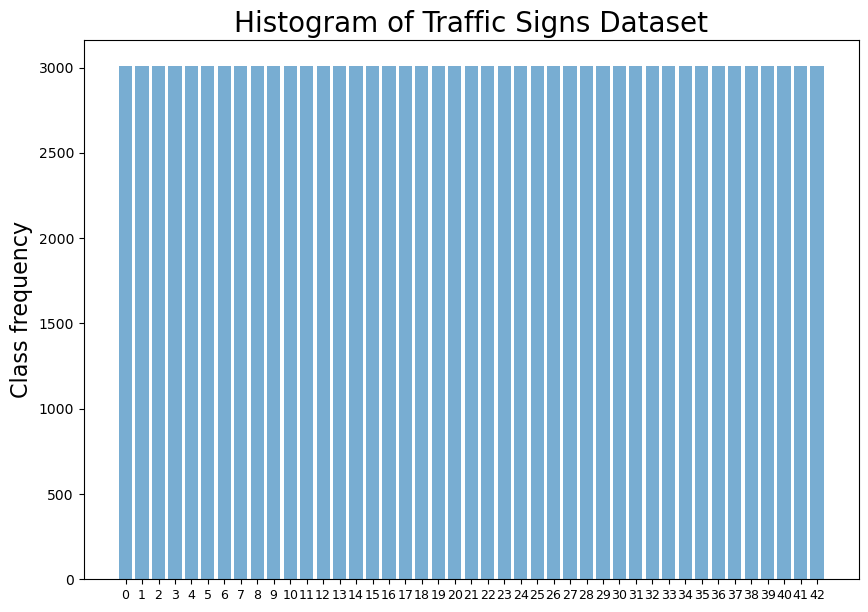

In [13]:
# Magic function that renders the figure in a jupyter notebook
# instead of displaying a figure object
%matplotlib inline


# Setting default size of the plot
plt.rcParams['figure.figsize'] = (10.0, 7.0)


# Calculating number of images for every class
# Iterating all classes' indexes in 'y_train' array
# Using Numpy function 'unique'
# Returning sorted unique elements and their frequencies
classesIndexes, classesFrequency = np.unique(y_train, return_counts=True)


# Printing frequency (number of images) for every class
print('classes indexes:' , classesIndexes)
print()
print('classes frequency:', classesFrequency)


# Plotting histogram of 43 classes with their number of images
# Defining a figure object 
figure = plt.figure()


# Plotting Bar chart
plt.bar(classesIndexes, classesFrequency, align='center', alpha=0.6)


# Giving name to Y axis
plt.ylabel('Class frequency', fontsize=16)


# Giving names to every Bar along X axis
plt.xticks(classesIndexes, fontsize=9)


# Giving name to the plot
plt.title('Histogram of Traffic Signs Dataset', fontsize=20)


# Saving the plot
figure.savefig('histogram_ts_images.png')


# Showing the plot
plt.show()


## Step 7: Shuffling data along the first axis

In [14]:
# Shuffling data along the first axis
# Saving appropriate connection: image --> label
x_train, y_train = shuffle(x_train, y_train)


# Check point
print('Shuffling is successfully finished')


Shuffling is successfully finished


## Step 8: Splitting arrays into train, validation and test

In [15]:
# Slicing first 30% of elements from Numpy arrays for training
# Assigning sliced elements to temp Numpy arrays
x_temp = x_train[:int(x_train.shape[0] * 0.3), :, :, :]
y_temp = y_train[:int(y_train.shape[0] * 0.3)]


# Slicing last 70% of elements from Numpy arrays for training
# Re-assigning sliced elements to train Numpy arrays
x_train = x_train[int(x_train.shape[0] * 0.3):, :, :, :]
y_train = y_train[int(y_train.shape[0] * 0.3):]


# Slicing first 80% of elements from temp Numpy arrays
# Assigning sliced elements to validation Numpy arrays
x_validation = x_temp[:int(x_temp.shape[0] * 0.8), :, :, :]
y_validation = y_temp[:int(y_temp.shape[0] * 0.8)]


# Slicing last 20% of elements from temp Numpy arrays
# Assigning sliced elements to test Numpy arrays
x_test = x_temp[int(x_temp.shape[0] * 0.8):, :, :, :]
y_test = y_temp[int(y_temp.shape[0] * 0.8):]


# Check point
print('Splitting is successfully finished')


Splitting is successfully finished


In [16]:
# Check point
# Showing shapes of arrays after splitting
print(x_train.shape)
print(y_train.shape)
print(x_validation.shape)
print(y_validation.shape)
print(x_test.shape)
print(y_test.shape)


(90601, 48, 48, 3)
(90601,)
(31063, 48, 48, 3)
(31063,)
(7766, 48, 48, 3)
(7766,)


## Step 9: Saving final Numpy arrays into one HDF5 binary file

In [17]:
# Saving prepared Numpy arrays into one HDF5 binary file
# Initiating File object
# Creating file with name 'dataset_ts_rgb_augmented.hdf5'
# Opening it in writing mode by 'w'
# (!) On Windows, it might need to change
# this: + '/' +
# to this: + '\' +
# or to this: + '\\' +
with h5py.File('ts' + '/' + 'dataset_ts_rgb_augmented.hdf5', 'w') as f:
    # Calling methods to create datasets of given shapes and types
    # Saving Numpy arrays for training
    f.create_dataset('x_train', data=x_train, dtype='f')
    f.create_dataset('y_train', data=y_train, dtype='i')

    # Saving Numpy arrays for validation
    f.create_dataset('x_validation', data=x_validation, dtype='f')
    f.create_dataset('y_validation', data=y_validation, dtype='i')

    # Saving Numpy arrays for testing
    f.create_dataset('x_test', data=x_test, dtype='f')
    f.create_dataset('y_test', data=y_test, dtype='i')


# Check point
print('Saving is successfully finished')


Saving is successfully finished


## Step 10: Visualizing 100 examples

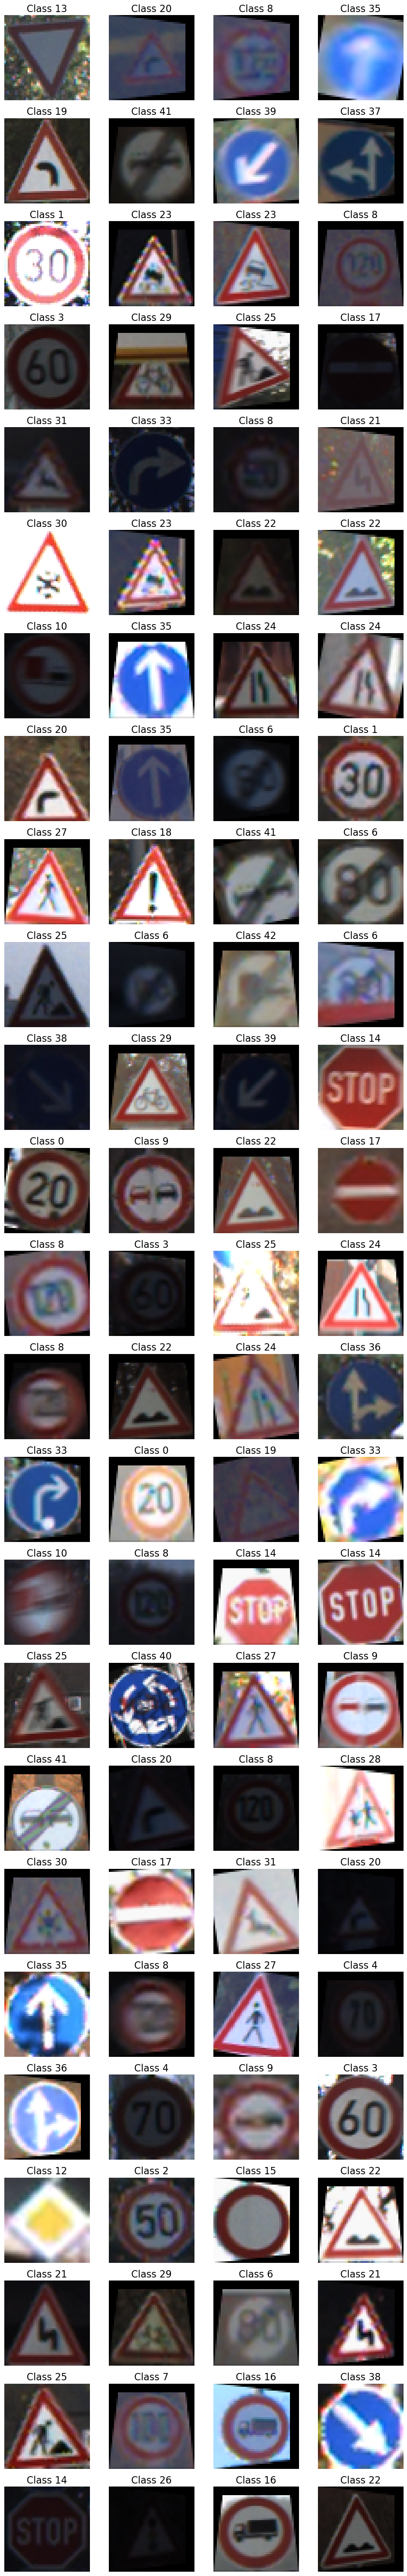

In [18]:
# Magic function that renders the figure in a jupyter notebook
# instead of displaying a figure object
%matplotlib inline


# Setting default size of the plot
plt.rcParams['figure.figsize'] = (10.0, 60.0)


# Defining a figure object with number of needed subplots
# ax is a (25, 4) Numpy array
# To access specific subplot we call it by ax[0, 0]
figure, ax = plt.subplots(nrows=25, ncols=4)


# Plotting 100 examples along 25 rows and 4 columns
for i in range(25):
    for j in range(4):
        # Preparing random index
        ii = np.random.randint(low=0, high=x_train.shape[0])
        
        # Plotting current subplot
        ax[i, j].imshow(x_train[ii].astype('uint8'))
        
        # Giving name to current subplot
        # according to class's name in list 'labels'
        ax[i, j].set_title('Class ' + str(y_train[ii]), fontsize=16)
        
        # Hiding axis
        ax[i, j].axis('off')


# Adjusting distance between subplots
plt.tight_layout()


# Showing the plot
plt.show()


### Some comments

To get more details for usage of 'np.copy':  
**print(help(np.copy))**
  
More details and examples are here:  
 - https://numpy.org/doc/stable/reference/generated/numpy.copy.html  


To get more details for usage of 'np.where':  
**print(help(np.where))**
  
More details and examples are here:  
 - https://numpy.org/doc/stable/reference/generated/numpy.where.html  


In [19]:
print(help(np.copy))

Help on function copy in module numpy:

copy(a, order='K', subok=False)
    Return an array copy of the given object.
    
    Parameters
    ----------
    a : array_like
        Input data.
    order : {'C', 'F', 'A', 'K'}, optional
        Controls the memory layout of the copy. 'C' means C-order,
        'F' means F-order, 'A' means 'F' if `a` is Fortran contiguous,
        'C' otherwise. 'K' means match the layout of `a` as closely
        as possible. (Note that this function and :meth:`ndarray.copy` are very
        similar, but have different default values for their order=
        arguments.)
    subok : bool, optional
        If True, then sub-classes will be passed-through, otherwise the
        returned array will be forced to be a base-class array (defaults to False).
    
        .. versionadded:: 1.19.0
    
    Returns
    -------
    arr : ndarray
        Array interpretation of `a`.
    
    See Also
    --------
    ndarray.copy : Preferred method for creating an arr

In [20]:
print(help(np.where))

Help on function where in module numpy:

where(...)
    where(condition, [x, y])
    
    Return elements chosen from `x` or `y` depending on `condition`.
    
    .. note::
        When only `condition` is provided, this function is a shorthand for
        ``np.asarray(condition).nonzero()``. Using `nonzero` directly should be
        preferred, as it behaves correctly for subclasses. The rest of this
        documentation covers only the case where all three arguments are
        provided.
    
    Parameters
    ----------
    condition : array_like, bool
        Where True, yield `x`, otherwise yield `y`.
    x, y : array_like
        Values from which to choose. `x`, `y` and `condition` need to be
        broadcastable to some shape.
    
    Returns
    -------
    out : ndarray
        An array with elements from `x` where `condition` is True, and elements
        from `y` elsewhere.
    
    See Also
    --------
    choose
    nonzero : The function that is called when x and y